Spot price AAPL: 213.75999450683594
Available expiration dates: ('2025-07-25', '2025-08-01', '2025-08-08', '2025-08-15', '2025-08-22', '2025-08-29', '2025-09-19', '2025-10-17', '2025-11-21', '2025-12-19', '2026-01-16', '2026-02-20', '2026-03-20', '2026-05-15', '2026-06-18', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')


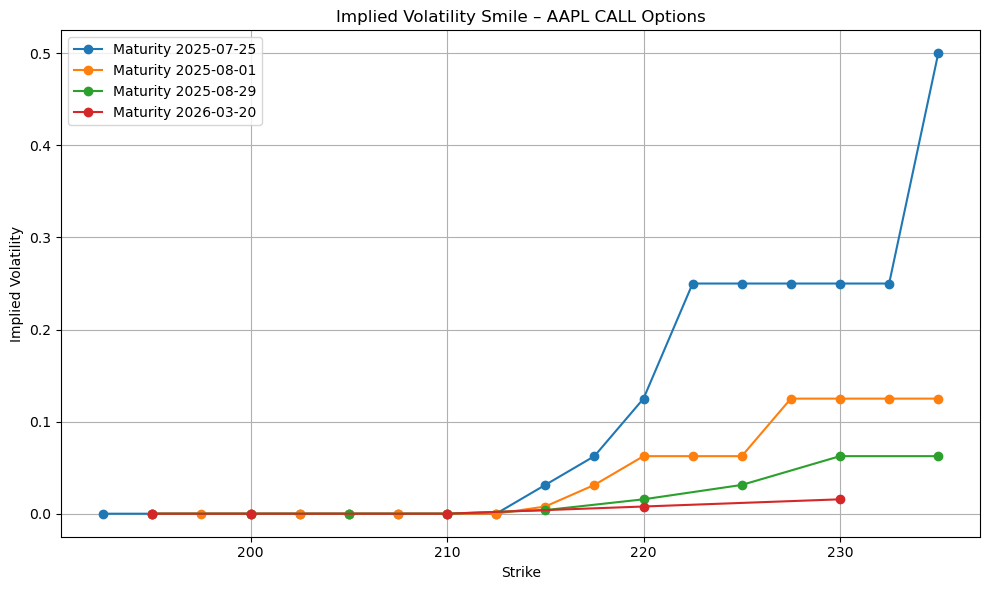

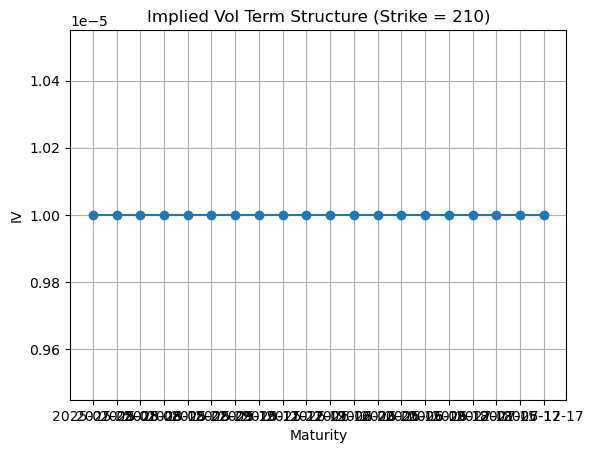

In [79]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Initialization
ticker = yf.Ticker("AAPL")

spot_price = ticker.history(period="1d")['Close'].iloc[-1]
print("Spot price AAPL:", spot_price)

# Available expiration dates
expirations = ticker.options
print("Available expiration dates:", expirations)

# Select 4 maturities: 1M, 2M, 6M, 1Y (if available)
selected_maturities = [expirations[0], expirations[1], expirations[5], expirations[12]]

# Plot: Implied volatility smile for each maturity
plt.figure(figsize=(10, 6))

for expiry in selected_maturities:
    chain = ticker.option_chain(expiry)
    calls = chain.calls

    # Filtering: volume > 10, price > 0, IV > 0, strike close to spot (+/-10%)
    lower_bound, upper_bound = 0.9 * spot_price, 1.1 * spot_price
    calls_liq = calls[
        (calls['volume'] > 10) &
        (calls['lastPrice'] > 0) &
        (calls['impliedVolatility'] > 0) &
        (calls['strike'] > lower_bound) &
        (calls['strike'] < upper_bound)
    ].copy()

    calls_liq['expiration']  = expiry

    # Plot
    plt.plot(
        calls_liq['strike'],
        calls_liq['impliedVolatility'],
        marker='o',
        label=f"Maturity {expiry}"
    )

plt.title("Implied Volatility Smile – AAPL CALL Options")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fixed_strike = 210 

maturities = []
Imp_vol = []

for expiry in expirations:
    chain = ticker.option_chain(expiry)
    calls = chain.calls
    calls_strike = calls[calls['strike'] == fixed_strike]

    if not calls_strike.empty:
        iv = calls_strike['impliedVolatility'].mean()
        maturities.append(expiry)
        Imp_vol.append(iv)

plt.plot(maturities, Imp_vol, marker='o')
plt.title(f"Implied Vol Term Structure (Strike = {fixed_strike})")
plt.xlabel("Maturity")
plt.ylabel("IV")
plt.grid(True)
plt.show()

In [53]:
def bs_price_vega(S, K, T, t, r, q, vol):
    """
    Compute European call price and vega under Black–Scholes.
    """
    tau = T - t
    if tau <= 0:
        return max(S - K, 0), 1 if S > K else 0
    d1 = (np.log(S/K) + (r - q + 0.5*vol**2)*tau) / (vol * np.sqrt(tau))
    d2 = d1 - vol * np.sqrt(tau)
    price = S * norm.cdf(d1) - K * np.exp(-r*tau) * norm.cdf(d2)
    vega = S * np.exp(-q*tau) * np.sqrt(tau)*norm.pdf(d1)
    return price, vega

def vol_Newton(S, K, T, t, r, q, vol_init, price_target, n_steps, eps = 1e-6):
    vol = vol_init
    price, vega = bs_price_vega(S, K, T, t, r, q, vol)
    for i in range (n_steps):
        price, vega = bs_price_vega(S, K, T, t, r, q, vol)
        diff = price - price_target
        if vega == 0 or abs(diff) < eps:
            break
        vol -= diff / vega
    return vol

In [81]:
import datetime as dt

# Set required parameters
today = dt.datetime.today()
r = 0.05
q = 0.00
vol_init = 0.2
n_steps = 252
eps = 1e-6

def compute_iv(row):
    try:
        K = row['strike']
        price_target = row['lastPrice']
        expiry = pd.to_datetime(row['expiration'])
        T = (expiry - today).days / 365
        if T <= 0 or price_target <= 0:
            return np.nan
        return vol_Newton(spot_price, K, T, 0, r, q, vol_init, price_target, n_steps, eps)
    except:
        return np.nan

def compute_bs_price(row):
    try:
        K = row['strike']
        expiry = pd.to_datetime(row['expiration'])
        T = (expiry - today).days / 365
        vol = row['impliedVol_calc']
        if T <= 0 or vol <= 0:
            return np.nan
        price, _ = bs_price_vega(spot_price, K, T, 0, r, q, vol)
        return price
    except:
        return np.nan

# Apply to the DataFrame of liquid options
calls_liq['impliedVol_calc'] = calls_liq.apply(compute_iv, axis=1)
calls_liq['comparison'] = calls_liq['impliedVolatility'] - calls_liq['impliedVol_calc']

calls_liq['BS_price'] = calls_liq.apply(compute_bs_price, axis=1)
calls_liq['price_diff'] = calls_liq['lastPrice'] - calls_liq['BS_price']

calls_liq.head()

# Possible reasons for discrepancies:
# Model differences between BS and Yahoo Finance
# Numerical approximation in Newton's method
# Noisy market prices
# Bid-ask spread, rounding, and illiquidity effects

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiration,impliedVol_calc,comparison,BS_price,price_diff
21,AAPL260320C00195000,2025-07-24 19:50:00+00:00,195.0,33.00,0.0,0.0,0.0,0.0,35,0,0.000010,True,REGULAR,USD,2026-03-20,0.275753,-0.275743,33.00,-1.349203e-08
22,AAPL260320C00200000,2025-07-24 19:59:35+00:00,200.0,29.10,0.0,0.0,0.0,0.0,29,0,0.000010,True,REGULAR,USD,2026-03-20,0.263060,-0.263050,29.10,-2.259597e-10
23,AAPL260320C00210000,2025-07-24 19:59:12+00:00,210.0,22.85,0.0,0.0,0.0,0.0,84,0,0.000010,True,REGULAR,USD,2026-03-20,0.255727,-0.255717,22.85,-2.131628e-14
24,AAPL260320C00220000,2025-07-24 19:54:59+00:00,220.0,17.60,0.0,0.0,0.0,0.0,229,0,0.007822,False,REGULAR,USD,2026-03-20,0.251240,-0.243418,17.60,2.545995e-09
25,AAPL260320C00230000,2025-07-24 19:55:03+00:00,230.0,12.92,0.0,0.0,0.0,0.0,149,4158,0.015635,False,REGULAR,USD,2026-03-20,0.242735,-0.227100,12.92,-2.086148e-07
